In [1]:
from pycolab import ascii_art
from pycolab.prefab_parts import sprites as prefab_sprites
from pycolab.rendering import ObservationToFeatureArray

import numpy as np
import pycolab

from tqdm import tqdm
from collections import namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

# Introduction

# Implementations

### Environments

#### 1. Blocking Maze

In [2]:
BLOCKING_MAZE = [
    ['###########',
     '#         #',
     '#         #',
     '#         #',
     '######### #',
     '#         #',
     '#         #',
     '###########'],
    ['###########',
     '#         #',
     '#         #',
     '#         #',
     '# #########',
     '#         #',
     '#         #',
     '###########']
]

#### 2. Shortcut Maze

In [3]:
SHORTCUT_MAZE = [
    ['###########',
     '#         #',
     '#         #',
     '#         #',
     '# #########',
     '#         #',
     '#         #',
     '###########'],
    ['###########',
     '#         #',
     '#         #',
     '#         #',
     '# ####### #',
     '#         #',
     '#         #',
     '###########']
]

#### 3. Environment Mechanics

In [4]:
def make_game(art):
    """Builds and returns game."""
    return ascii_art.ascii_art_to_game(art, what_lies_beneath=' ', sprites={'P': PlayerSprite})


def show_board(obs):
    """Displays an image of the Board."""
    board = 80 * np.array(obs.layers['P'], dtype=np.float)
    board += 15 * np.array(obs.layers['#'], dtype=np.float)
    board += 50 * np.array(obs.layers['G'], dtype=np.float)

    plt.figure(figsize=(4, 2))
    plt.imshow(board)
    plt.axis('off')
    plt.show()


class PlayerSprite(prefab_sprites.MazeWalker):
    """A `Sprite` for our player.
    This `Sprite` ties actions to going in the four cardinal directions. If we
    reach a magical location, the agent receives a reward of 1 and the epsiode terminates.
    """

    def __init__(self, corner, position, character):
        """Inform superclass that the '#' delimits the walls."""
        super(PlayerSprite, self).__init__(corner, position, character, impassable='#')
    


    def update(self, actions, board, layers, backdrop, things, the_plot):
        del backdrop, things   # Unused in this application.

        # Apply motion commands.
        if actions == 0:    # walk upward?
            self._north(board, the_plot)
            #print('Walks up')
        elif actions == 1:  # walk downward?
            self._south(board, the_plot)
            #print('Walks down')
        elif actions == 2:  # walk leftward?
            self._west(board, the_plot)
            #print('Walks left')
        elif actions == 3:  # walk rightward?
            self._east(board, the_plot)
            #print('Walks right')

        # See if we've found the mystery spot.
        if layers["G"][self.position]:
            the_plot.add_reward(1.0)
            the_plot.terminate_episode()
        else:
            the_plot.add_reward(0.0)
            


In [5]:
class Maze(object):
    def __init__(self, arts, start, goal):
        self.arts = arts
        self.index = 0
        
        self.START = start
        self.GOAL  = goal
    
    def _set_art(self, art, marker, position):
        y, x = position
        tmp = list(art[y])
        tmp[x] = marker
        art[y] = "".join(tmp)
    
    def build(self):
        art = self.arts[self.index]
        self._set_art(art, "P", self.START)  # add the player's position
        #self._set_art(art, "S", self.START)  # add the start's position
        self._set_art(art, "G", self.GOAL)  # add the goal's position
        self.game = make_game(art)
        return self
    
    def select(self, i):
        assert i < len(self.arts), "Index out of bounds. Should be between {} and {}".format(0, len(self.arts)-1)
        self.index = i
        return self
    
    def its_showtime(self):
        obs, reward, gamma = self.game.its_showtime()
        return obs, reward, gamma
    
    def play(self, action):
        obs, reward, gamma = self.game.play(action)
        return obs, reward, gamma    
    
    @property
    def rows(self):
        return self.game.rows
    
    @property
    def cols(self):
        return self.game.cols
    
    @property
    def game_over(self):
        return self.game.game_over

### Dyna-Q Algorithm

In [6]:
class SimpleModel(object):
    def __init__(self):
        self._mapping = dict()
    
    def feed(self, state, action, next_state, reward):
        if tuple(state) not in self._mapping.keys():
            self._mapping[tuple(state)] = dict()
        self._mapping[tuple(state)][action] = (reward, list(next_state))
    
    def sample(self):
        #
        state_index = np.random.choice(range(0, len(self._mapping.keys())))
        state = list(self._mapping)[state_index]
        #
        action_index = np.random.choice(range(0, len(self._mapping[state].keys())))
        action = list(self._mapping[state])[action_index]
        reward, next_state = self._mapping[state][action]
        return list(state), action, reward, list(next_state)

In [19]:
class DynaQ(object):
    def __init__(self, gamma=0.95, epsilon=0.1, alpha=0.1, n_planning_steps=5):
        # discount factor
        self.gamma = gamma

        # probability for exploration
        self.epsilon = epsilon

        # step size
        self.alpha = alpha

        # n-step planning
        self.n_planning_steps = n_planning_steps
        
    # action selection with epsilon-greedy scheme
    def _select_action(self, state, state_action_values):
        # flip a coin with probability epsilon to have 1 ...
        if np.random.binomial(1, self.epsilon) == 1:
            # if it's the case randomly pick an action amongst ALL ACTIONS.
            return np.random.randint(4)
        else:
            # otherwise, pick an action (at random) amongst ACTIONS OF MAXIMUM VALUE (if many)
            values = state_action_values[state[0], state[1], :]
            return np.random.choice(np.where(values == np.max(values))[0])

    # tabular dyna-Q algorithm
    def apply(self, state_action_values, model, game, n_steps, display=False):
        #
        obs, reward, gamma = game.its_showtime()
        position = np.array(obs.layers['P'])
        current_state = np.unravel_index(position.argmax(), position.shape)
        
        if display:
            show_board(obs)

        steps = 0
        while not(game.game_over):
            #
            steps += 1

            # choose an action to execute
            action = self._select_action(current_state, state_action_values)

            # take action
            obs, reward, gamma = game.play(action)
            position = np.array(obs.layers['P'])
            next_state = np.unravel_index(position.argmax(), position.shape)
            
            if display:
                show_board(obs)

            # Q-Learning update
            state_action_values[current_state[0], current_state[1], action] += \
                self.alpha * (reward + self.gamma * np.max(state_action_values[next_state[0], next_state[1], :]) -
                state_action_values[current_state[0], current_state[1], action])

            # feed the model with experience
            model.feed(current_state, action, next_state, reward)

            # sample experience from the model
            for t in range(0, self.n_planning_steps):
                sample_state, sample_action, sample_reward, sample_next_state = model.sample()
                state_action_values[sample_state[0], sample_state[1], sample_action] += \
                    self.alpha * (sample_reward + self.gamma * np.max(state_action_values[sample_next_state[0], sample_next_state[1], :]) -
                    state_action_values[sample_state[0], sample_state[1], sample_action])

            current_state = next_state
            
            if steps > n_steps:
                break
        return steps

In [8]:
def changing_maze_experiment(maze_arts, params):

    # set up max steps
    n_steps = params.n_steps

    # track the cumulative rewards
    rewards = np.zeros((n_steps,))

    for run in tqdm(range(0, params.n_runs)):
        
        # instantiate dyna-Q algorithm
        agent = DynaQ(alpha=0.7)
        
        # set up model
        model = SimpleModel()

        # track cumulative reward in current run
        rewards_ = np.zeros((n_steps,))
        
        # instantiate game
        maze = Maze(maze_arts, start=(6, 4), goal=(1, 9))
        game = maze.select(0).build()
        index = game.index

        # initialize state action values
        state_action_values = np.zeros((game.rows, game.cols, 4))

        steps = 0
        last_steps = steps
        while steps < n_steps:
            # play for an episode
            steps += agent.apply(state_action_values, model, game, n_steps, False)

            # update cumulative rewards
            steps_ = min(steps, n_steps - 1)
            rewards_[last_steps : steps_] = rewards_[last_steps]
            rewards_[steps_] = rewards_[last_steps] + 1
            last_steps = steps
            
            
            if index < len(params.change_points) and steps > params.change_points[index]:
                # change maze
                game = maze.select(1).build()
                index = game.index
            else:
                # keep same maze (rebuild)                
                game = maze.build()
                index = game.index
        rewards += rewards_

    # averaging over runs
    rewards /= params.n_runs

    return rewards

100%|██████████| 20/20 [00:17<00:00,  1.13it/s]


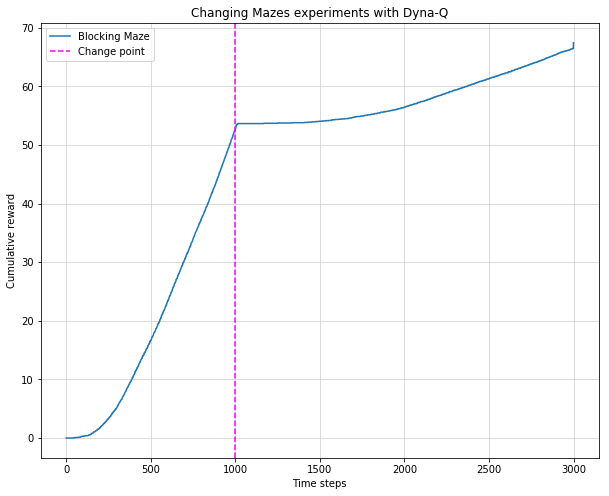

In [31]:
# parameters for experiments
Params = namedtuple("Params", ["n_steps", "n_runs", "change_points"])
params = Params(n_steps=3000, n_runs=20, change_points=[1000, np.inf])

# run the experiments on both "blocking maze" and "shortcut maze"
rewards_bm = changing_maze_experiment(BLOCKING_MAZE, params)
#rewards_sm = changing_maze_experiment(SHORTCUT_MAZE, params)

# plot results
plt.figure(figsize=(10, 8))
plt.plot(range(0, params.n_steps), rewards_bm, label="Blocking Maze")
#plt.plot(range(0, params.n_steps), rewards_sm, label="Changing Maze")
plt.axvline(params.change_points[0], color="magenta", linestyle="--", label="Change point")
plt.title('Changing Mazes experiments with Dyna-Q')
plt.xlabel('Time steps')
plt.ylabel('Cumulative reward')
plt.legend(loc="best")
plt.grid(True, color="lightgrey")
plt.show()

# Experiments

# How dows Dyna-Q relate to Experience Replay ?

# Conclusion